<i>

PREFACE: <br>
This document contains an Exploratory Data Analysis as part of the machine learning pipeline. <br>
Its purpose is to help understand the underlying structure and relationships within the data.
</i>


# BACKGROUND STORY
Maximizing solar power generation requires careful planning and resource allocation. To optimize energy output, it's essential to predict periods of high and low solar efficiency based on weather forecasts. By storing excess energy generated during peak performance times, you can ensure a consistent power supply. Conversely, periods of low efficiency can be used for system maintenance without significant production losses. Your role as an AI engineer involves developing models to accurately predict solar panel efficiency, enabling data-driven decisions for operational optimization and cost reduction.

<b> TLDR: To develop models that classify solar panel efficiency as 'Low', 'Medium' or 'High' by leveraging historical same day forecasted data. </b>


--------------------------------------------------
## DATA PROCESSING SUMMARY

| Step | Description |
|------|-------------|
| 1 | **Drop duplicates**: This step removes duplicate rows from the weather_df and air_quality_df dataframes based on the 'data_ref' column. The first occurrence of each duplicate row is kept, and the rest are dropped. |
| 2 | **Merge dataframes**: This step merges the weather_df and air_quality_df dataframes on the 'date' and 'data_ref' columns using an inner join. The resulting dataframe is stored in the merged_df variable. |
| 3 | **Drop 'data_ref' column**: This step drops the 'data_ref' column from the merged_df dataframe. |
| 4 | **Replace missing values with None**: This step replaces the '-' and '--' values in the merged_df dataframe with None. |
| 5 | **Convert columns to numeric where possible**: This step attempts to convert all columns in the merged_df dataframe to numeric data type using the pd.to_numeric() function. Columns that cannot be converted to numeric are skipped. |
| 6 | **Fill in relevant rainfall columns with 0**: This step defines a function zero_rainfall_relationship() that fills in certain rainfall columns with 0 based on specific conditions. The function is then applied to each row of the merged_df dataframe using the apply() function. |
| 7 | **Absolute value of 'Max Wind Speed (km/h)'**: This step takes the absolute value of the 'Max Wind Speed (km/h)' column in the merged_df dataframe. |
| 8 | **Convert to 'Wet Bulb Temperature (deg C)**: This step converts the 'Wet Bulb Temperature (deg F)' column to 'Wet Bulb Temperature (deg C)' by applying the formula (F - 32) * 5 / 9. The resulting column is rounded to 1 decimal place. The original column is then dropped from the merged_df dataframe. |
| 9 | **Map 'Dew Point Category' to numerical values**: This step maps the values in the 'Dew Point Category' column of the merged_df dataframe to numerical values based on the mapping dictionary dewpointmap. |
| 10 | **Map 'Wind Direction' to standardized values**: This step maps the values in the 'Wind Direction' column of the merged_df dataframe to standardized values based on the mapping dictionary winddirmap. |
| 11 | **Map 'Daily Solar Panel Efficiency' to numerical values**: This step maps the values in the 'Daily Solar Panel Efficiency' column of the merged_df dataframe to numerical values based on the mapping dictionary efficiencymap. |
| 12 | **Convert 'date' to datetime**: This step converts the 'date' column of the merged_df dataframe to datetime format. It then extracts the 'day_of_year' and 'year' information from the date. Additionally, it calculates the total number of days in a year based on whether it is a leap year or not. Finally, it creates sine and cosine transformation features ('day_sin' and 'day_cos') based on the 'day_of_year' information. Intermediate columns are dropped from the dataframe. |
| 13 | **Map wind directions to angles (in degrees)**: This step defines a mapping dictionary wind_direction_angles that maps wind directions to angles in degrees. |
| 14 | **Create sine cosine transformation function for wind direction**: This step defines a function transform_winddir() that converts wind directions to angles using the mapping dictionary wind_direction_angles. It then converts the angles to radians and applies sine and cosine transformations to create 'wind_dir_sin' and 'wind_dir_cos' columns. The original wind direction columns are dropped from the dataframe. |
| 15 | **Fix missing data**: This step fixes all the null values to create a clean dataframe. It drops rows with null values in the columns 'Sunshine Duration (hrs)' and 'Cloud Cover (%)'. It interpolates the missing values in the columns 'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', and 'Max Wind Speed (km/h)' using linear interpolation. It imputes missing rainfall data based on domain-specific rules. It interpolates missing values in air quality columns ('pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central') using linear interpolation. Finally, it drops any remaining rows with null values that couldn't be interpolated.



--------------------------------------------------
## CONTENTS:
1. Initialise the Environment
2. Column Definitions List
3. Dataset Column Analysis
4. Column Entry Value Analysis
5. Missing Data Analysis
6. Correlation and Trend Analysis
<br>

## 1. Initialise the Environment

In [1]:
############################################
# Add the src directory for the module imports
import sys
sys.path.append('src')
############################################

from helper.data_processing import drop_duplicates, merge_dataframes, drop_column, replace_with_none, datatype_to_float, rainfall_zero_relationship, absolute_value, convert_wet_bulb_temp_f_to_c, map_dew_point_category,map_wind_direction,map_solar_panel_efficiency, transform_date, transform_winddir, interpolate_missing
from utils import load_df, load_config, printunique
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Suppress all warning messages.
warnings.filterwarnings("ignore")

# Load the config file
config = load_config("./config/config.yaml")

# Load the dataset into dataframe.
weather_df, air_quality_df = load_df(config)

# Modify display settings to be able to see all columns
pd.set_option('display.max_columns', None) 
# Modify display settings to show up to 4significant figures
pd.set_option('display.float_format', '{:.3g}'.format) 


## 2. Column Definitions List

| Attribute            |Description                                                                         |
| :----------------------------- | :---------------------------------------------------------------------------------- |
| data_ref                     | A unique alpha-numeric entry generated by computer.                                 |
| date                         | The date when the data was recorded.                                                |
| Wet bulb temperature         | Temperature incorporating humidity effect.                                          |
| Daily Rainfall Total (mm)    | Total rainfall recorded in a day, in millimeters.                                    |
| Highest 30 Min Rainfall (mm) | Maximum rainfall in any 30-minute period of the day, in millimeters.                |
| Highest 60 Min Rainfall (mm) | Maximum rainfall in any 60-minute period of the day, in millimeters.                |
| Highest 120 Min Rainfall (mm)| Maximum rainfall in any 120-minute period of the day, in millimeters.               |
| Min Temperature (deg C)       | Minimum temperature of the day, in Celsius.                                           |
| Maximum Temperature (deg C)    | Highest temperature recorded on the day, in Celsius.                                  |
| Min Wind Speed (km/h)        | Minimum wind speed of the day, in km/h.                                              |
| Max Wind Speed (km/h)        | Maximum wind speed recorded on the day, in km/h.                                     |
| Sunshine Duration (hrs)      | Duration of sunshine in hours for the day.                                         |
| Cloud Cover (%)             | Percentage of the sky covered by clouds.                                             |
| Relative Humidity (%)        | Average relative humidity for the day, in percentage.                                |
| Air Pressure (hPa)           | Atmospheric air pressure, in hectopascal (hPa).                                     |
| Dew Point Category           | Category of dew point temperature conditions.                                       |
| Wind Direction               | General direction from which the wind is coming.                                     |
| Daily Solar Panel Efficiency | Efficiency rate of solar panels for the day.                                        |




| Attribute        | Description                                                    |
| :---------------- | :------------------------------------------------------------- |
| data_ref        | A unique alpha-numeric entry generated by computer.            |
| date            | The date when the data was recorded.                           |
| PM25 North      | Particulate matter of 2.5 micrometers in the north.           |
| PM25 South      | Particulate matter of 2.5 micrometers in the south.           |
| PM25 East       | Particulate matter of 2.5 micrometers in the east.            |
| PM25 West       | Particulate matter of 2.5 micrometers in the west.            |
| PM25 Central    | Particulate matter of 2.5 micrometers in the central area.    |
| PSI North       | Pollutant Standards Index in the north.                        |
| PSI South       | Pollutant Standards Index in the south.                        |
| PSI East        | Pollutant Standards Index in the east.                         |
| PSI West        | Pollutant Standards Index in the west.                         |
| PSI Central     | Pollutant Standards Index in the central area.                 |


## 3. Dataset Column Analysis

In [2]:
print(weather_df.info(),weather_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)   3517 non-null   f

In [3]:
print(air_quality_df.info(), air_quality_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3875 entries, 0 to 3874
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_ref      3875 non-null   object
 1   date          3875 non-null   object
 2   pm25_north    3836 non-null   object
 3   pm25_south    3836 non-null   object
 4   pm25_east     3836 non-null   object
 5   pm25_west     3836 non-null   object
 6   pm25_central  3836 non-null   object
 7   psi_north     3836 non-null   object
 8   psi_south     3836 non-null   object
 9   psi_east      3836 non-null   object
 10  psi_west      3836 non-null   object
 11  psi_central   3836 non-null   object
dtypes: object(12)
memory usage: 363.4+ KB
None                                data_ref        date pm25_north pm25_south  \
0  4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea  01/04/2014         20         16   
1  c9d3c825-fd94-4e61-a4bc-2cf0f2208de0  02/04/2014         18         14   
2  6d445ffb-d4c2-4f94-a27e

## 3. Dataset Column Analysis

Let's take a quick look at the columns of the datasets!

- **Weather Dataframe**: Contains a total of 18 features and ~3.5k entries.
- **Air Quality Dataframe**: Contains ~3.8k entries with 12 features.

By examining the first 10 rows of each dataset, it appears that the `data_ref` and `date` columns match. If this is confirmed, these columns will be used to merge the two datasets. We anticipate dropping around 300 entries due to the mismatch in dataset sizes. After merging, we can remove the `data_ref` column as it is only a data label and does not contribute to our prediction.

### Handling Null Values

Both dataframes contain null values, and some null values are not properly registered. For example, the column `Highest 120 Min Rainfall (mm)` has values such as `'-'` and `'--'`, yet it still shows 3197 non-null object counts. These values will be converted to `None` before further data processing.

### Rainfall Data in Weather Dataframe

For the four rainfall columns in the weather dataframe, we can summarize the relationship as follows:
- `Daily Rainfall Total >= Highest 120 Min Rainfall >= Highest 60 Min Rainfall >= Highest 30 Min Rainfall`

If there is no rain (i.e., `Daily Rainfall Total` is 0 or `Highest 30 Min Rainfall` is 0), all the other values will also be zero. If `Daily Rainfall` equals `Highest 60 Min Rainfall`, then `Highest 120 Min Rainfall` will also equal `Highest 60 Min Rainfall`, and so on. This relationship can be used to fill in some of the missing values.

### Air Quality Dataframe

The air quality dataframe shows that columns 2 to 6 are missing exactly 39 entries. If these missing entries are all in the same rows, those rows will be removed. However, the first 10 rows indicate that the missing entries are in different rows, so further analysis is required to determine how to handle this missing data.

### Data Types

Most of the data types in both dataframes are objects. For proper data processing, columns with numerical values need to be converted to the float datatype. If necessary, these can be downcast to integers at the end to save memory.



<font color="#7070FF">
**Things to do (cumulative):**

1. Check if `data_ref` and `date` columns match in the two dataframes.
2. Merge the two dataframes.
3. Remove the `data_ref` column from the two dataframes.
4. Convert `'-'` and `'--'` to `None` in both dataframes.
5. Fill in relevant rainfall columns using the defined relationship.
6. Analyze and handle missing data.
7. Convert numerical datatypes to floats.

</font>


## 4. Column Value Analysis

In [4]:
printunique(weather_df)   

Unique length of 'data_ref' : 3197 

Unique length of 'date' : 3197 

Unique length of 'Daily Rainfall Total (mm)' : 243 

Unique length of 'Highest 30 Min Rainfall (mm)' : 170 

Unique length of 'Highest 60 Min Rainfall (mm)' : 198 

Unique length of 'Highest 120 Min Rainfall (mm)' : 218 

Unique length of 'Min Temperature (deg C)' : 72 

Unique length of 'Maximum Temperature (deg C)' : 102 

Unique length of 'Min Wind Speed (km/h)' : 142 

Unique length of 'Max Wind Speed (km/h)' : 205 

Unique length of 'Sunshine Duration (hrs)' : 545 

Unique length of 'Cloud Cover (%)' : 100 

Unique length of 'Wet Bulb Temperature (deg F)' : 89 

Unique length of 'Relative Humidity (%)' : 218 

Unique length of 'Air Pressure (hPa)' : 23 

Unique length of 'Dew Point Category' : 25 

Unique length of 'Wind Direction' : 32 

Unique length of 'Daily Solar Panel Efficiency' : 3 

Unique values in 'data_ref' : ['4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea'
 'c9d3c825-fd94-4e61-a4bc-2cf0f2208de0'
 '6d445ffb-d

In [5]:
printunique(air_quality_df)   

Unique length of 'data_ref' : 3197 

Unique length of 'date' : 3197 

Unique length of 'pm25_north' : 75 

Unique length of 'pm25_south' : 87 

Unique length of 'pm25_east' : 77 

Unique length of 'pm25_west' : 86 

Unique length of 'pm25_central' : 69 

Unique length of 'psi_north' : 113 

Unique length of 'psi_south' : 114 

Unique length of 'psi_east' : 109 

Unique length of 'psi_west' : 118 

Unique length of 'psi_central' : 106 

Unique values in 'data_ref' : ['4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea'
 'c9d3c825-fd94-4e61-a4bc-2cf0f2208de0'
 '6d445ffb-d4c2-4f94-a27e-224fabe46d10' ...
 'da402a4c-4d07-47d3-8439-411e23e615ef'
 '4c67f80b-faec-44d4-861e-dc5a1e8c5186'
 '2d850015-fbac-4a9b-b1d1-8f4925a7ee5b'] 

Unique values in 'date' : ['01/04/2014' '02/04/2014' '03/04/2014' ... '29/07/2020' '29/08/2017'
 '19/08/2020'] 

Unique values in 'pm25_north' : ['20' '18' '12' '--' '22' '-' '19' '24' '25' '31' '27' '32' '23' '29' '16'
 '26' '30' '11' '15' '17' '13' '28' '10' '9' '8' '14' '21' '54'

## 4. Column Value Analysis

### Unexpected Values Observed

**Data_ref & Date**: The unique length for `data_ref` and `date` in both datasets is 3197, indicating duplicated entries in both datasets that should be removed.

**Max Wind Speed**: This column has negative values, like -37.1. Since there is a wind direction column, the speed should only have positive values. We will assume the negative sign is a mistake and there is no need to reverse the direction value.

**Wet Bulb Temperature**: Measured in degrees Fahrenheit, this column also has negative values. We will convert these values to degrees Celsius for easier comparison with other columns like `min temperature`. Most values are around 50-60°F, and it would be impossible for the temperature to change drastically from 60°F to -60°F in one day. We assume the values are correct, but the negative sign is an error that needs to be fixed.

**Dew Point**: This column has too many repeated categories (e.g., VH, Very High, VERY HIGH, very high, Extreme). We will combine these into five numeric categories from very low to very high (1, 2, 3, 4, 5).

**Wind Direction**: This column also has many repeated categories (e.g., S, Southward, south, SOUTH, S.). We will combine these into eight categories: NE, NW, N, E, W, S, SE, SW.

**Air Quality Columns**: All columns, except for `data_ref` and `date`, have missing values represented by `-`, `--`, and `None`.

### Conversion to Numerical Values

Machine learning models typically require numerical input, so we need to convert all categorical information into numerical values.

**Date Column**: The cyclical nature of dates (e.g., days of the year) is difficult for models to understand. For instance, January 1st and December 31st are far apart in days of the year (1st and 365th) but are very close in terms of the season. We will convert the day of the year into sine and cosine components to represent the date's position within a year as a point on a circle. `day_sin` will vary from -1 to 1 and capture the vertical position on the circle, while `day_cos` will capture the horizontal position.

**Wind Direction**: Similar to dates, one-hot encoding will not capture the cyclical nature of wind direction (e.g., N is close to NE and NW). We will use sine and cosine transformation for wind direction instead.

**Daily Solar Panel Efficiency**: Values will be converted from low, medium, and high efficiency to numerical values (0, 1, and 2, respectively).



<font color="#7070FF">
**Things to do (cumulative):**

1. Check if `data_ref` and `date` columns match in the two dataframes.
2. Merge the two dataframes.
3. Remove the `data_ref` column from both dataframes.
4. Convert `'-'` and `'--'` to `None` in both dataframes.
5. Fill in relevant rainfall columns with 0.
6. Analyze and handle missing data.
7. Convert numerical data types to floats.
8. Remove duplicated entries in `data_ref` and `date` columns in both datasets.
9. Fix negative values in the `max wind speed` column.
10. Fix negative values in the `wet bulb temperature` column.
11. Convert `wet bulb temperature` to degrees Celsius.
12. Combine and convert `dew point` values into five numerical categories.
13. Combine `wind direction` values into eight categories.
14. Convert `date` to `day_sin` and `day_cos`.
15. Convert `wind direction` to `wind_dir_sin` and `wind_dir_cos`.
16. Convert `daily solar panel efficiency` from low, medium, and high to 0, 1, and 2, respectively.
</font>


In [6]:
#########################################################################################
# 1 Drop duplicates in both dataframes
weather_df = drop_duplicates(weather_df, 'data_ref')
air_quality_df = drop_duplicates(air_quality_df, 'data_ref')

#########################################################################################
# 2 Merge the two dataframes on 'date' and 'data_ref'
merged_df = merge_dataframes(weather_df, air_quality_df, ['date', 'data_ref'])

#########################################################################################
# 3 Drop 'data_ref' column
merged_df = drop_column(merged_df, 'data_ref')

#########################################################################################
# 4 Replace missing values with None
merged_df = replace_with_none(merged_df, '-')
merged_df = replace_with_none(merged_df, '--')

#########################################################################################
# 5 Convert columns to numeric where possible
merged_df = datatype_to_float(merged_df)

#########################################################################################        
# 6 Fill in relevant rainfall columns with 0.
merged_df = rainfall_zero_relationship(merged_df)

#########################################################################################
# 7 Absolute value of 'Max Wind Speed (km/h)'
merged_df = absolute_value(merged_df, 'Max Wind Speed (km/h)')

#########################################################################################
# 8 Absolute value of 'Wet Bulb Temperature (deg F)'
merged_df = absolute_value(merged_df, 'Wet Bulb Temperature (deg F)')

#########################################################################################
# 9 Convert 'Wet Bulb Temperature (deg F)' to 'Wet Bulb Temperature (deg C)' 
# and drop the original column
merged_df = convert_wet_bulb_temp_f_to_c(merged_df, 'Wet Bulb Temperature (deg F)', 
											'Wet Bulb Temperature (deg C)')

#########################################################################################
# 10 Map 'Dew Point Category' to numerical values
merged_df = map_dew_point_category(merged_df, 'Dew Point Category')

#########################################################################################
# 11 Map 'Wind Direction' to standardized values
merged_df = map_wind_direction(merged_df, 'Wind Direction')

#########################################################################################
# 12 Map 'Daily Solar Panel Efficiency' to numerical values
merged_df = map_solar_panel_efficiency(merged_df, 'Daily Solar Panel Efficiency')

#########################################################################################
# 13 Sine and cosine transformation of 'Date'
merged_df = transform_date(merged_df)

#########################################################################################
# 14 Sine and cosine transformation of 'Wind Direction'
merged_df = transform_winddir(merged_df)

#########################################################################################

## 5. Analysis of Missing Data

**********************************************************************************
There are three types of missing data:
- **MCAR**: Missing Completely at Random means that the missingness is unrelated to any observed or unobserved data. The fact that data is missing is completely random, and there is no systematic pattern. For example, a temperature reading is missing because a sensor was accidentally turned off, regardless of the temperature value.
- **MAR**: Missing At Random means that the missingness is related to some observed data but not to the missing data itself. The probability of missing data can be explained by other observed variables. For example, temperature readings are missing more often when the humidity is high. Here, humidity is observed and explains the missingness.
- **MNAR**: Missing Not At Random means that the missingness is related to the value of the data itself or other unobserved variables. The fact that data is missing is systematically related to the missing values. For example, temperature readings are missing because sensors tend to fail at extreme temperatures. Here, the missingness depends on the value of the temperature itself.

When handling the missing data, we need to keep in mind:
- **MCAR**: Data can be safely removed or imputed without biasing the results.
- **MAR**: Use imputation methods that leverage the observed data to fill in missing values.
- **MNAR**: Imputation is challenging and may require modeling the missing data mechanism.
**********************************************************************************

Let's analyze the data using the methods below to decide on how to fix the missing data:
- Use a missing data heatmap.
- Calculate the amount of missing data.
- Check the statistics of the data.

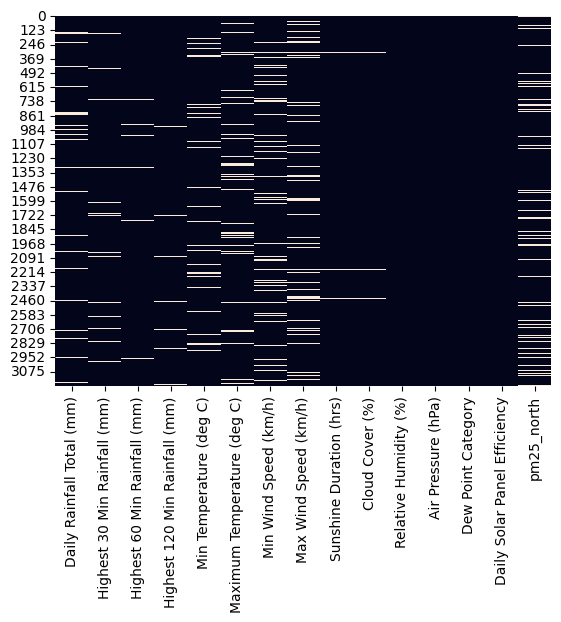

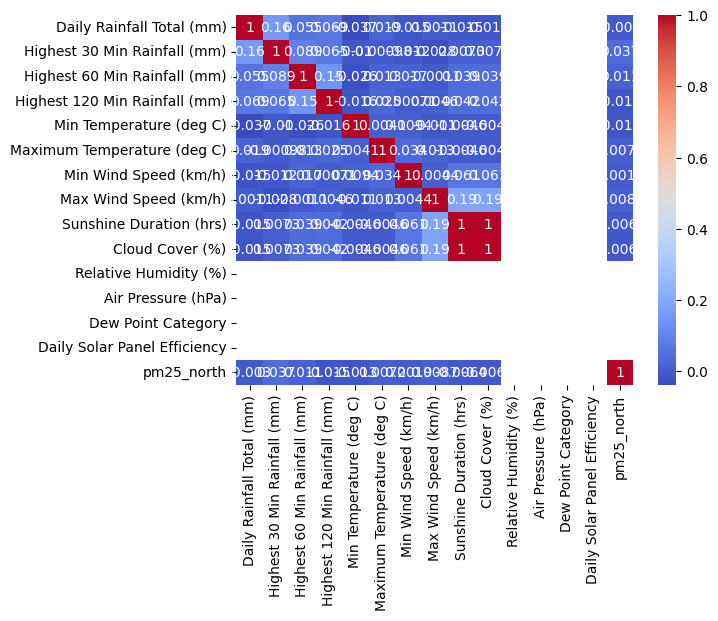

In [7]:
# Split the Dataframe back into 2 for heatmap

weather_df = merged_df.iloc[:, 0:15]  # Columns 0 to 10
air_quality_df = merged_df.iloc[:, 15:30] 

# Null Values Heatmap - weather
sns.heatmap(weather_df.isnull(), cbar=False)
plt.show()
sns.heatmap(weather_df.isnull().corr(), annot=True, cmap='coolwarm')
plt.show()

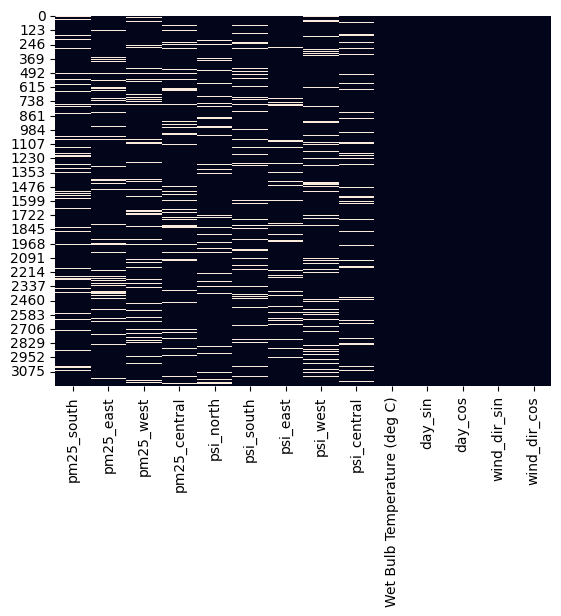

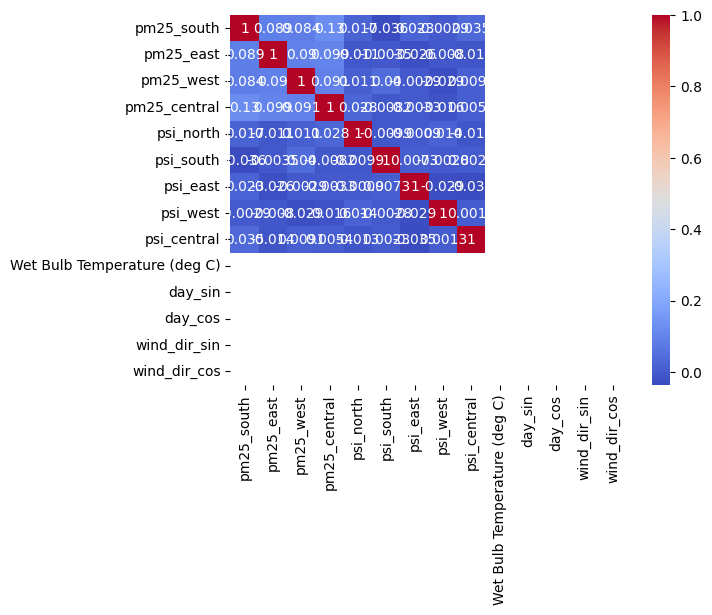

In [8]:
# Null Values Heatmap - air quality
sns.heatmap(air_quality_df.isnull(), cbar=False)
plt.show()
sns.heatmap(air_quality_df.isnull().corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
# Find the row number where Cloud Cover has missing data
print(np.where(weather_df['Cloud Cover (%)'].isnull()))
# Print the surrounding rows of data
print(weather_df.iloc[310:325])

(array([ 315,  316,  317,  318,  904, 2192, 2204, 2312, 2342, 2437, 2440,
       2443, 2478]),)
     Daily Rainfall Total (mm)  Highest 30 Min Rainfall (mm)  \
310                          0                             0   
311                        NaN                           6.4   
312                        0.2                           0.2   
313                          0                             0   
314                          0                             0   
315                          0                             0   
316                          0                             0   
317                          0                             0   
318                          0                             0   
319                          0                             0   
320                          0                             0   
321                          0                             0   
322                          0                             0   
323     

## 6. Missing Data Analysis

From examining the heatmap and the first 30 rows, we observe that most missing data are well spread out with no clear trend or cluster, suggesting they are MCAR. However, "Sunshine Duration" and "Cloud Cover" consistently have missing data simultaneously, indicating a MNAR pattern.

Upon further investigation of the surrounding rows of the missing "Sunshine Duration" and "Cloud Cover" data, no additional insights were found. Given that some missing data are consecutive and not suitable for linear interpolation, and considering the small number of missing values (13 out of 3197, approximately 0.4%), we have decided to drop these rows with missing "Sunshine Duration" and "Cloud Cover" values. This conservative approach ensures that we maintain the integrity of our dataset without introducing significant bias.


In [10]:
# Dropping of rows for Sunshine Duration and Cloud Cover is combined into the interpolate_missing function below.

In [11]:
merged_df.head(30)

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central,Wet Bulb Temperature (deg C),day_sin,day_cos,wind_dir_sin,wind_dir_cos
0,NaN,2,2,2,28.4,32.4,7.5,25.9,8.07,18,100,1.01e+03,5,2,20,16,18,23,19,58,56,57,66,59,15.2,1,0.0043,-1,-0
1,0,0,0,0,28.8,32.6,NaN,33.1,7.57,23,100,1e+03,5,1,18,14,NaN,22,16,57,53,54,61,56,15.1,1,-0.0129,0,-1
2,0,0,0,0,29.3,NaN,NaN,43.2,6.72,16,98.5,1e+03,2,1,12,12,10,14,10,55,53,52,59,54,15.4,1,-0.0301,1,0
3,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20,100,1.01e+03,5,1,NaN,NaN,24,19,25,58,57,55,NaN,56,15.1,0.999,-0.0473,-1,-0
4,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74,100,1.01e+03,5,0,18,19,21,13,17,64,64,66,NaN,66,14.9,0.998,-0.0645,1,0
5,0.2,0.2,0.2,0.2,28,32.5,10.4,34.6,7.39,13,81.7,1.01e+03,5,0,NaN,11,11,8,11,54,NaN,55,41,52,15.1,0.997,-0.0817,0.707,0.707
6,10,9.8,10,10,28.6,34.5,7.6,43.2,5.75,40,100,1.01e+03,5,0,12,12,15,14,10,47,42,51,46,47,14.8,0.995,-0.0988,1,0
7,6.6,4.2,4.8,6.2,27.6,32.8,6.9,NaN,7.47,35,100,1e+03,5,0,22,NaN,14,21,19,57,55,54,56,54,14.9,0.993,-0.116,-0.707,0.707
8,1.8,1.4,1.8,1.8,27.6,34,7.2,37.1,7.13,10,100,1.01e+03,5,1,NaN,12,19,16,18,61,56,60,57,58,15.2,0.991,-0.133,0,-1
9,0,0,0,0,28,31.8,6.2,29.2,7.88,15,100,1e+03,3,1,19,12,15,20,14,60,55,58,59,NaN,15.1,0.989,-0.15,1,0


In [12]:
# Column with the most null values
col_name = merged_df.isnull().sum().idxmax()
# Amount of null values
col_value = merged_df.isnull().sum().max()
# Percentage of null values
col_percent = round((col_value / len(merged_df[col_name]) * 100),1)

print("Column with the most null values:",col_name,'=', col_value)
print("Percentage of null values = ", col_percent )
print("\nNumber of null values in column: \n", merged_df.isnull().sum())

Column with the most null values: pm25_south = 349
Percentage of null values =  10.9

Number of null values in column: 
 Daily Rainfall Total (mm)        173
Highest 30 Min Rainfall (mm)     165
Highest 60 Min Rainfall (mm)     119
Highest 120 Min Rainfall (mm)    109
Min Temperature (deg C)          314
Maximum Temperature (deg C)      314
Min Wind Speed (km/h)            319
Max Wind Speed (km/h)            328
Sunshine Duration (hrs)           13
Cloud Cover (%)                   13
Relative Humidity (%)              0
Air Pressure (hPa)                 0
Dew Point Category                 0
Daily Solar Panel Efficiency       0
pm25_north                       345
pm25_south                       349
pm25_east                        344
pm25_west                        347
pm25_central                     348
psi_north                        310
psi_south                        307
psi_east                         312
psi_west                         310
psi_central                 

In [13]:
merged_df.describe()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Daily Solar Panel Efficiency,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central,Wet Bulb Temperature (deg C),day_sin,day_cos,wind_dir_sin,wind_dir_cos
count,3.02e+03,3.03e+03,3.08e+03,3.09e+03,2.88e+03,2.88e+03,2.88e+03,2.87e+03,3.18e+03,3.18e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,2.85e+03,2.85e+03,2.85e+03,2.85e+03,2.85e+03,2.89e+03,2.89e+03,2.88e+03,2.89e+03,2.88e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03,3.2e+03
mean,4.99,2.97,3.53,4.07,28.1,31.7,8.79,32.7,7.02,28.7,97.4,1.01e+03,4.55,0.956,14.9,14.6,14.4,13.6,14.1,51.6,50.5,50.7,48.2,50.1,15,-0.0179,-0.018,0.00659,-0.00197
std,12.2,6.47,7.98,9.24,1.09,1.48,3,6.54,1.38,20.7,5.01,3.5,1.01,0.672,10.5,12,10.8,12.1,9.27,15.3,16.6,15.2,17.9,14.4,0.413,0.707,0.707,0.705,0.71
min,0,0,0,0,23,23.7,0.4,14.8,0,2,68.6,998,1,0,4,3,3,2,3,18,16,17,15,17,12.9,-1,-1,-1,-1
25%,0,0,0,0,27.4,31,6.5,28.2,6.71,17,96.8,1.01e+03,5,1,10,9,9,8,9,43,41,42,37,41,14.7,-0.722,-0.721,-0.707,-0.707
50%,0,0,0,0,28.2,32,8,32,7.4,22,100,1.01e+03,5,1,13,12,12,11,12,52,52,52,49,52,15,-0.043,-0.0473,0,0
75%,3.8,2.4,2.6,3,28.9,32.7,10.8,36.4,7.84,30,100,1.01e+03,5,1,17,16,16,16,16,57,56,57,56,56,15.2,0.693,0.69,0.707,0.707
max,211,53.4,73.8,85.6,30.7,35.4,21.4,70.6,9.15,100,100,1.02e+03,5,2,199,235,176,197,176,265,288,253,276,238,16.6,1,1,1,1


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      3024 non-null   float64
 1   Highest 30 Min Rainfall (mm)   3032 non-null   float64
 2   Highest 60 Min Rainfall (mm)   3078 non-null   float64
 3   Highest 120 Min Rainfall (mm)  3088 non-null   float64
 4   Min Temperature (deg C)        2883 non-null   float64
 5   Maximum Temperature (deg C)    2883 non-null   float64
 6   Min Wind Speed (km/h)          2878 non-null   float64
 7   Max Wind Speed (km/h)          2869 non-null   float64
 8   Sunshine Duration (hrs)        3184 non-null   float64
 9   Cloud Cover (%)                3184 non-null   float64
 10  Relative Humidity (%)          3197 non-null   float64
 11  Air Pressure (hPa)             3197 non-null   float64
 12  Dew Point Category             3197 non-null   i


## 6. Missing Data Analysis

Building on our previous insights, we note that the maximum amount of missing values in our dataset is 10.9%. While this is borderline large, removing such a significant portion of data could lead to substantial information loss. Therefore, we have decided to impute the missing values instead of discarding them.

Two common methods for addressing missing values are filling with zero or performing interpolation. Given the temporal structure of our weather data, linear interpolation is the more suitable approach. Weather typically changes gradually from day to day, so we can use the values from adjacent days to estimate missing values.

However, for the rainfall columns, we observe that their standard deviation is high (SD > 2x Mean), indicating rapid changes from day to day. This makes them unsuitable for linear interpolation. Instead, we will utilize the inherent relationship among the rainfall measurements:
Daily Rainfall Total ≥ Highest 120 Min Rainfall ≥ Highest 60 Min Rainfall ≥ Highest 30 Min Rainfall.
This relationship will guide us in imputing the missing values more accurately for these columns.

It is important to note that interpolation can introduce bias by averaging out data and reducing the impact of outliers. Our interpolation method tends to produce estimated values that are smaller than the actual values. This could introduce a slight bias towards smaller values in our dataset.


In [15]:
#########################################################################################
# 15. Missing data processing section

merged_df = interpolate_missing(merged_df)
#########################################################################################

## 7. Correlation and Trend Analysis

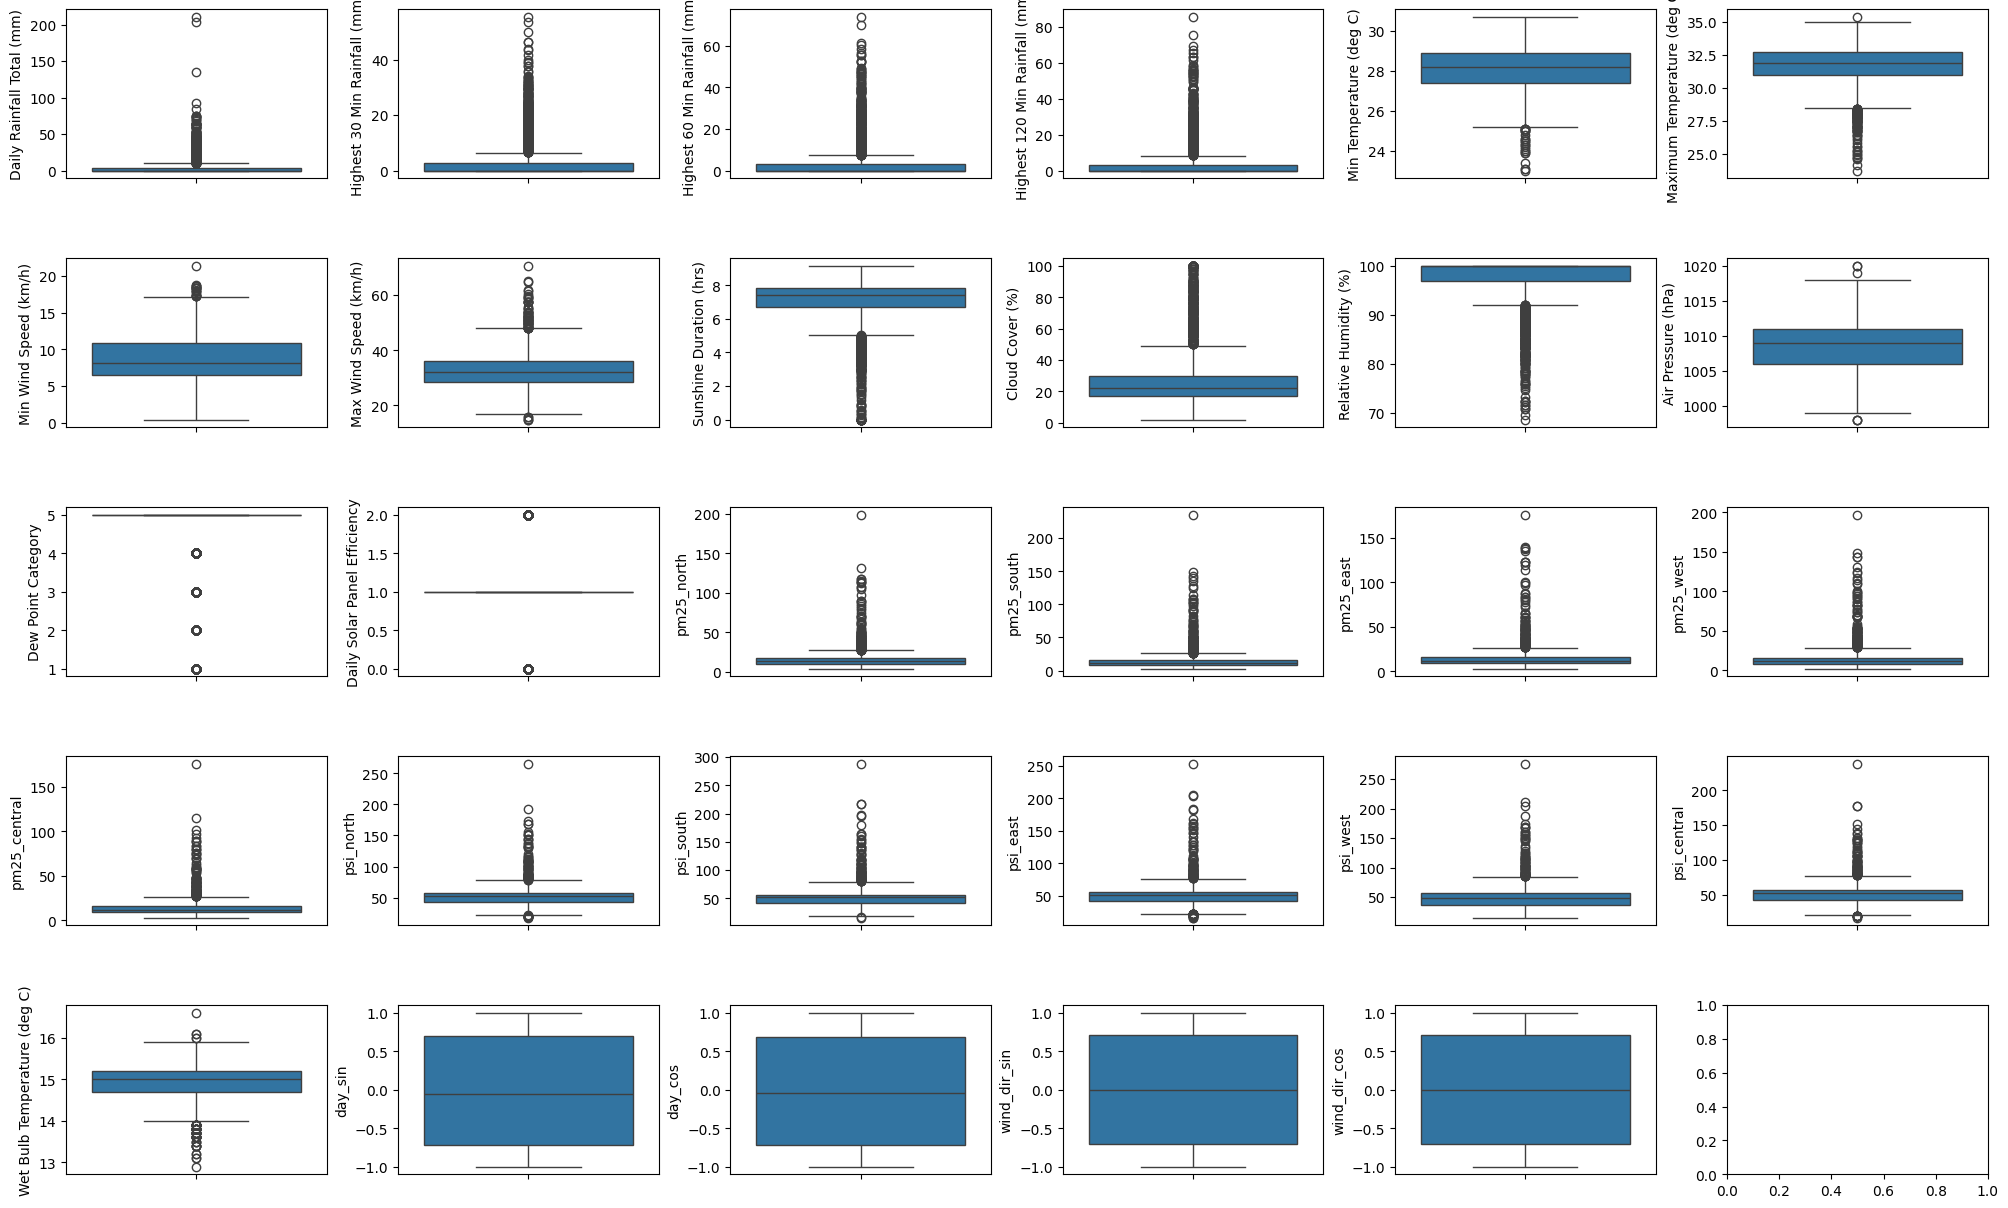

In [16]:
# Boxplot

fig, axs = plt.subplots(ncols=6, nrows=5, figsize=(20,12))
index = 0
axs = axs.flatten()
for k,v in merged_df.items():
    sns.boxplot(y=k, data=merged_df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

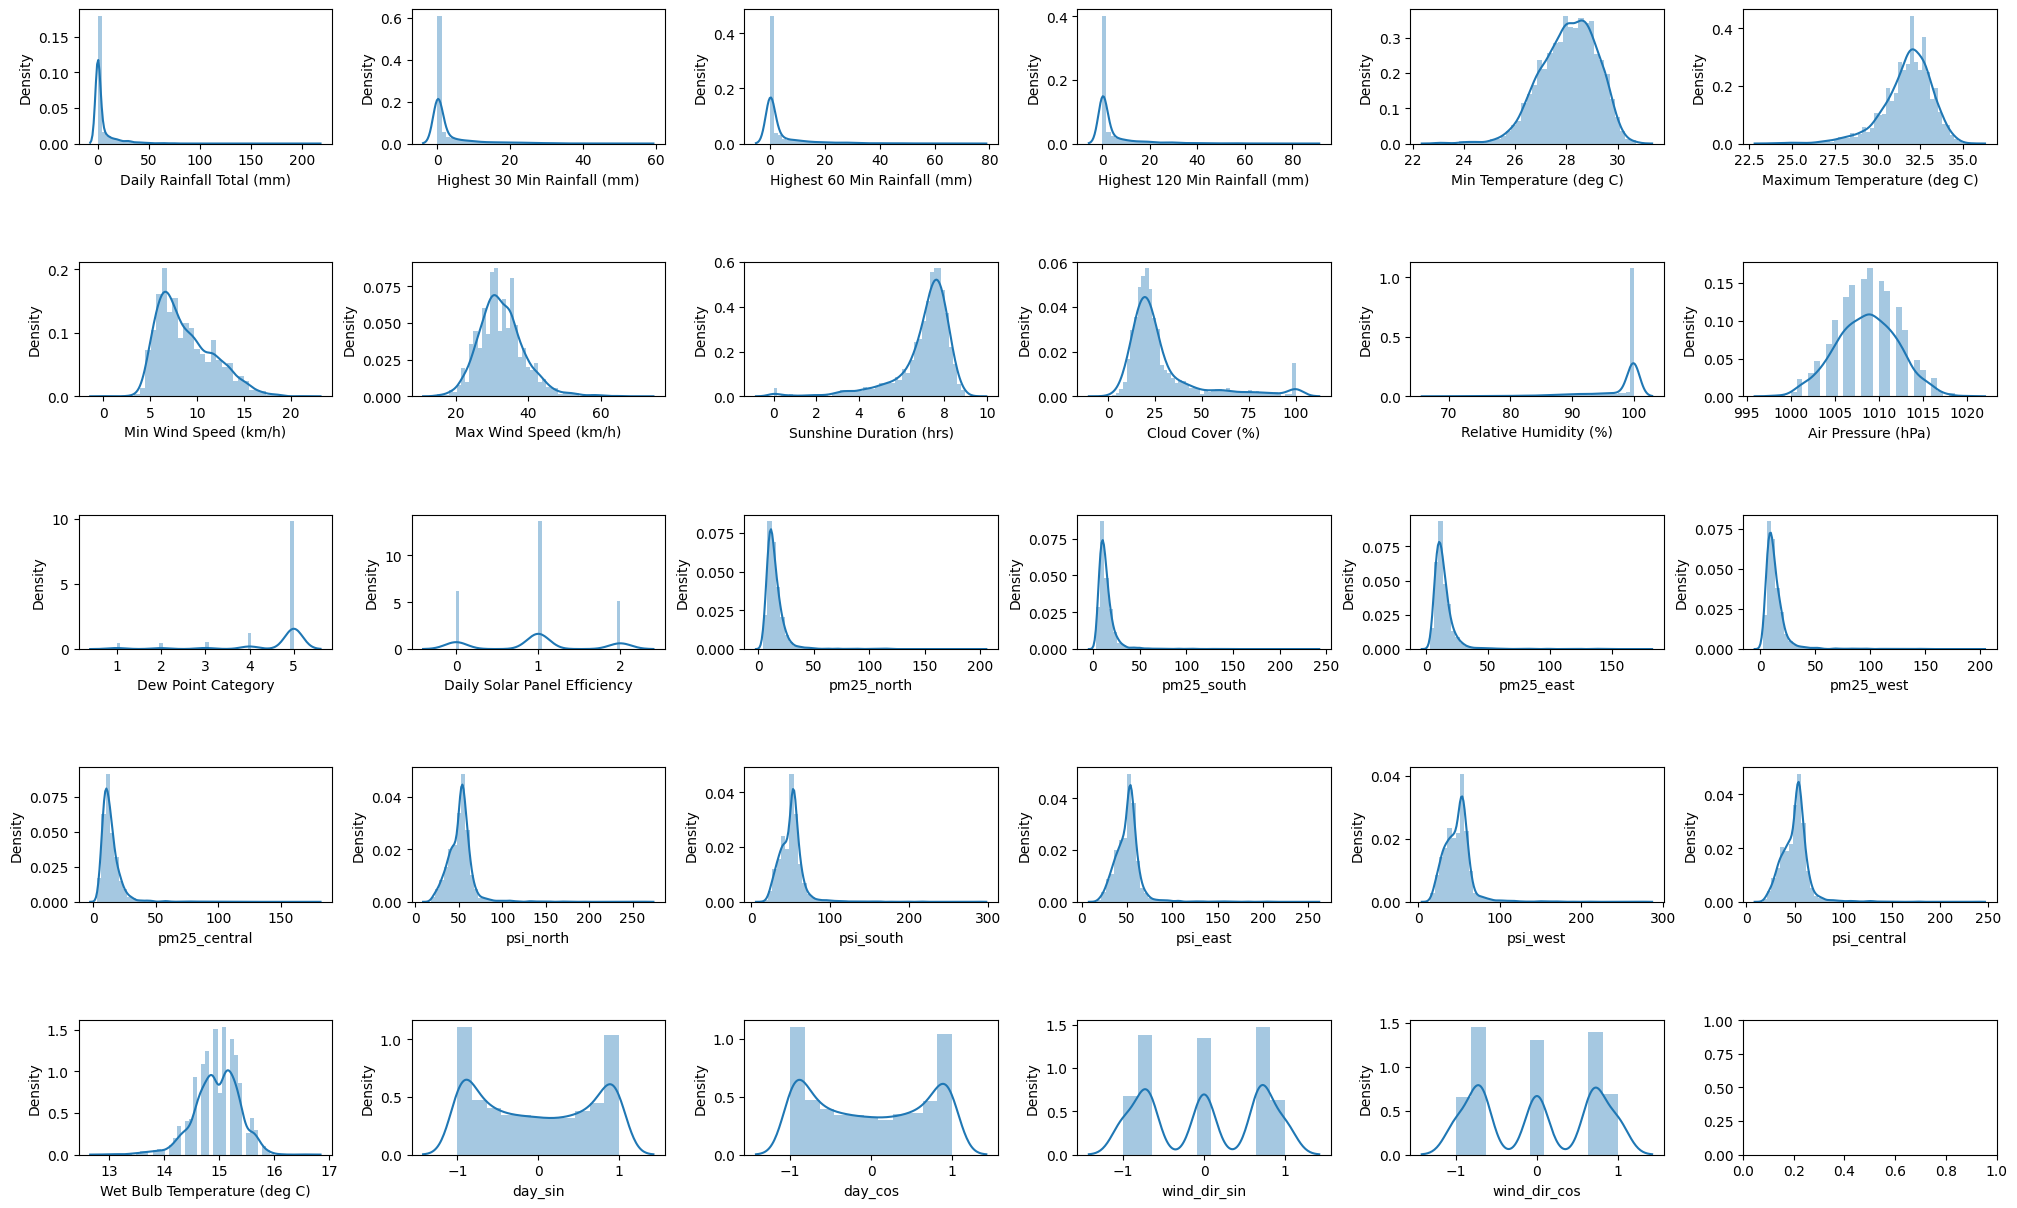

In [19]:
# Distribution plot
fig, axs = plt.subplots(ncols=6, nrows=5, figsize=(20,12))
index = 0
axs = axs.flatten()
for k,v in merged_df.items():
    sns.distplot(v, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)



In [18]:
#Print correlation values for target feature 'Daily Solar Panel Efficiency'
correlation_series = merged_df.corr()['Daily Solar Panel Efficiency'].sort_values(ascending=False)
print(correlation_series)

Daily Solar Panel Efficiency           1
Sunshine Duration (hrs)            0.508
Min Temperature (deg C)            0.265
Maximum Temperature (deg C)         0.19
pm25_central                       0.105
pm25_east                         0.0923
pm25_south                        0.0913
pm25_west                           0.09
pm25_north                         0.088
psi_central                       0.0833
psi_east                          0.0755
Wet Bulb Temperature (deg C)      0.0725
psi_west                          0.0725
psi_north                         0.0705
Min Wind Speed (km/h)             0.0702
psi_south                         0.0695
day_sin                           0.0319
wind_dir_cos                      0.0105
wind_dir_sin                     0.00147
Dew Point Category              -0.00255
day_cos                          -0.0031
Air Pressure (hPa)               -0.0345
Relative Humidity (%)             -0.166
Max Wind Speed (km/h)             -0.234
Daily Rainfall T

## 7. Correlation and Trend Analysis

After processing the data according to the "Things to do" list, let's further examine the dataset by looking at the frequency plot of each column and the correlation values.

**Observations:**
- **Outliers**: There are quite alot of outliers seen in the boxplot. As this is weather data, we do expect some extreme weather from time to time. Without further domain knowledge, we choose not to remove any outliers.
- **Rainfall Columns**: These columns are right-skewed with a peak at 0.
- **Min and Max Temperature**: Both appear to follow a normal distribution.
- **Min Wind Speed**: Values drop rapidly below 4, possibly indicating that the sensor is not sensitive enough for low wind speeds.
- **Max Wind Speed**: Appears to follow a normal distribution.
- **Sunshine Duration**: Shows a small peak at 0.
- **Cloud Cover**: Exhibits a peak that is four times larger at 100. This may or may not indicate an error, as high cloud cover is necessary to block all sunshine.
- **Relative Humidity**: Heavily skewed towards 100.
- **Air Pressure**: Appears to follow a normal distribution.
- **Dew Point**: Heavily skewed towards 5 (very high).
- **Daily Solar Panel Efficiency**: Shows a slightly uneven spread (25-55-20).
- **PM2.5 and PSI**: Both are right-skewed.
- **Sunshine Duration Correlation**: Has the highest correlation value of 0.508 with solar panel efficiency. This makes sense as long periods of sunshine are necessary for solar panels to generate more energy. The correlation is not higher possibly because it doesn't account for the strength of the sunshine; long periods of weak sunshine are not productive for solar panels.

We conclude that no further data processing is required. 


# 8. Machine Learning Evaluation Metric

**********************************************************************************
**Training Accuracy vs. Cross-Validation Accuracy**

* If the training accuracy is much higher than the CV accuracy, it suggests overfitting.
* If both are low, it suggests underfitting.

**Cross-Validation Accuracy vs. Test Accuracy**

* If the CV accuracy is close to the test accuracy, it indicates that the model generalizes well to new data.
* If the test accuracy is significantly lower than the CV accuracy, it might indicate that the CV process was not completely representative, possibly due to data leakage or an inadequate CV strategy.

**********************************************************************************


For evaluating our models, we will use accuracy as the primary metric. <br>
Accuracy measures the proportion of correctly predicted instances out of the total, providing a clear baseline for comparison.

-----------------------------------------------------

## Food for thoughts...

For the purpose of managing operational cost, the indirect objective of this project, it may be advantageous to create a weekend/PH column. This is in consideration that you have to pay less for weekday maintenance. If there are two or more appropriate low-efficiency periods, it is possible to save costs by selecting the weekday period. 
